# Weapon Detection Optimization Experiment


#### Libraries


In [65]:
%%capture
# data-gradients
# latest library version
!pip install -U -q git+https://github.com/Deci-AI/data-gradients.git@v0.2.2

!pip install data-gradients

# to get data from roboflow
!pip install roboflow

# for displaying pdfs as images in notebook
!pip install pdf2image
!apt-get install poppler-utils

# for pretty printing json
!pip install Pygments

In [76]:
import os
import git
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor
from data_gradients.datasets.detection import YoloFormatDetectionDataset
from data_gradients.managers.detection_manager import DetectionAnalysisManager

In [27]:
!pip show data_gradients

Name: data-gradients
Version: 0.2.2
Summary: DataGradients
Home-page: https://github.com/Deci-AI/data-gradients
Author: Deci AI
Author-email: rnd@deci.ai
License: 
Location: /home/repl/.local/lib/python3.8/site-packages
Requires: coverage, hydra-core, imagededup, jinja2, matplotlib, numpy, omegaconf, opencv-python, Pillow, platformdirs, pygments, rapidfuzz, scipy, seaborn, tensorboard, torch, torchvision, tqdm, xhtml2pdf
Required-by: 


#### Prerequisites for Explanatory Data Analysis


In [31]:
async def download_github_images(local_dir, github_url, max_retries=3):
    async with ClientSession() as session:
        async with session.get(github_url) as response:
            if response.status == 200:
                html = await response.text()
                soup = BeautifulSoup(html, "html.parser")
                links = soup.find_all("a", class_="js-navigation-open")

                os.makedirs(local_dir, exist_ok=True)

                async def download_image(link):
                    image_filename = link["title"]
                    raw_image_url = "https://raw.githubusercontent.com" + link["href"]

                    retries = 0
                    success = False
                    while not success and retries < max_retries:
                        async with session.get(raw_image_url) as image_response:
                            if image_response.status == 200:
                                image_data = await image_response.read()
                                with open(
                                    os.path.join(local_dir, image_filename), "wb"
                                ) as image_file:
                                    image_file.write(image_data)
                                print(f"Downloaded: {image_filename}")
                                success = True
                            else:
                                retries += 1
                                print(
                                    f"Failed to download: {image_filename}, retrying ({retries}/{max_retries})"
                                )

                async def download_label(link):
                    label_filename = link["title"]
                    raw_label_url = "https://raw.githubusercontent.com" + link["href"]

                    retries = 0
                    success = False
                    while not success and retries < max_retries:
                        async with session.get(raw_label_url) as label_response:
                            if label_response.status == 200:
                                label_data = await label_response.read()
                                with open(
                                    os.path.join(local_dir, label_filename), "wb"
                                ) as label_file:
                                    label_file.write(label_data)
                                print(f"Downloaded: {label_filename}")
                                success = True
                            else:
                                retries += 1
                                print(
                                    f"Failed to download: {label_filename}, retrying ({retries}/{max_retries})"
                                )

                image_links = [link for link in links if link["title"].endswith(".jpg")]
                label_links = [link for link in links if link["title"].endswith(".txt")]

                image_tasks = [download_image(link) for link in image_links]
                label_tasks = [download_label(link) for link in label_links]

                await asyncio.gather(*image_tasks)
                await asyncio.gather(*label_tasks)

                print("All images and labels downloaded successfully.")
            else:
                print("Failed to access the GitHub URL.")

#### Download Image Dataset into our workspace using direct github links


In [12]:
# Download the Train Test Images
local_dir_image_train = "weapon_train_test_dataset/images/train"
github_url_image_train = "https://github.com/ari-dasci/OD-WeaponDetection/tree/master/Weapons%20and%20similar%20handled%20objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/images/train"

local_dir_image_test = "weapon_train_test_dataset/images/test"
github_url_image_test = "https://github.com/ari-dasci/OD-WeaponDetection/tree/master/Weapons%20and%20similar%20handled%20objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/images/test"

# Download the Train and Test Labels
local_dir_label_train = "weapon_train_test_dataset/labels/train"
github_url_label_train = "https://github.com/ari-dasci/OD-WeaponDetection/tree/master/Weapons%20and%20similar%20handled%20objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/labels/train"

local_dir_label_test = "weapon_train_test_dataset/labels/test"
github_url_label_test = "https://github.com/ari-dasci/OD-WeaponDetection/tree/master/Weapons%20and%20similar%20handled%20objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/labels/test"

download_github_files(local_dir_image_train, github_url_image_train)
download_github_files(local_dir_image_test, github_url_image_test)
download_github_files(local_dir_label_train, github_url_label_train)
download_github_files(local_dir_label_test, github_url_label_test)

In [13]:
download_github_images(local_directory, github_url, max_retries=3)

<coroutine object download_github_images at 0x7f7a255858c0>

#### Downloaded all Image data into our Workspace


In [4]:
# Set the path to our workspace 
workspace = "/work/files/workspace/"
%cd $workspace

# Provide the URL of the Git repository you want to clone
repository_url = "https://github.com/brooksideas/OD-weapon-detection-dataset.git"

# Provide the local directory where you want to clone the repository
local_directory = "./weapon_train_test_dataset"

# Create the local directory if it doesn't exist
# if not os.path.exists(local_directory):
#     os.makedirs(local_directory)

# # Clone the repository
# repo = git.Repo.clone_from(repository_url, local_directory)

# We now have the cloned repository in the local directory

/work/files/workspace


#### Our Working Root Directory


In [77]:
# Set the path to our workspace
root_directory = "/work/files/workspace/weapon_train_test_dataset/data/weapon_detection/train_test_data"

#### Resize all images for consistency


In [81]:
# Specify the target image size
# target_width, target_height = 512, 512
def calculate_scaling_factor(original_size, target_size):
    # Calculate the scaling factor based on the original and target sizes
    return (target_size[0] / original_size[0], target_size[1] / original_size[1])


# Define a function to resize an image and update the format annotations
def resize_image_and_annotations(image_path, annotation_path):
    # Read the image using cv2
    image = cv2.imread(image_path)

    # Resize the image using cv2
    image = cv2.resize(image, (target_width, target_height))

    # Save the resized image
    cv2.imwrite(image_path, image)

    # Uncomment this line if you want to persist changes
    # Update the annotation file with new dimensions
    # with open(annotation_path, 'r') as file:
    #     lines = file.readlines()

    # Update the bounding box coordinates in the format
    updated_lines = []
    for line in lines:
        filename_with_extension = os.path.basename(annotation_path)
        filename, extension = os.path.splitext(filename_with_extension)
        # We need a dict variable Original imageSize for all image files as
        # imageSize = {
        #   image1.jpg: (1920,1090),
        #   image2.jpg (720,1080)
        # }
        #
        current_img = imageSizes.get(filename, (1024, 1024))
        target_size = (512, 512)
        scaling_factor = calculate_scaling_factor(current_img, target_size)

        values = line.strip().split()
        if len(values) == 5:  # (class_id, x_center, y_center, width, height)
            class_id, x_center, y_center, width, height = values
            x_center, y_center, width, height = (
                float(x_center),
                float(y_center),
                float(width),
                float(height),
            )

            # Scale the coordinates based on the new image size
            x_center *= scaling_factor[0]
            y_center *= scaling_factor[1]
            width *= scaling_factor[0]
            height *= scaling_factor[1]

            updated_line = f"{class_id} {x_center} {y_center} {width} {height}\n"
            updated_lines.append(updated_line)
        else:
            updated_lines.append(line)

    # Uncomment this line if you want to persist changes
    # Save the updated annotation
    # with open(annotation_path, 'w') as file:
    #     file.writelines(updated_lines)


def directory_for_image_and_annotation_resize(directory_name):
    # Specify the root directory with images and annotations
    data_dir = root_directory

    # Specify the subdirectories for images and labels (train set)
    images_dir = os.path.join(data_dir, "images", directory_name)
    labels_dir = os.path.join(data_dir, "labels", directory_name)

    # Initialize a counter for the total number of updates
    update_count = 0

    # Loop through image files in the "train/test" directory
    for image_filename in os.listdir(images_dir):
        # Check if the file is an image file (JPEG format)
        if image_filename.lower().endswith((".jpg", ".jpeg")):
            image_path = os.path.join(images_dir, image_filename)
            annotation_filename = os.path.splitext(image_filename)[0] + ".txt"
            annotation_path = os.path.join(labels_dir, annotation_filename)

            # Check if the image size matches the target size
            image = cv2.imread(image_path)
            image_height, image_width, _ = image.shape
            resize_image_and_annotations(image_path, annotation_path)
            update_count += 1
            # Check if the image is indeed of different size from our target
            if image_width != target_width or image_height != target_height:
                # Resize images and update annotations as needed
                resize_image_and_annotations(image_path, annotation_path)
                update_count += 1
                print(
                    f"Successfully processed {image_filename} and {annotation_filename}."
                )
            else:
                update_count += 1
                print(
                    f"Skipping {image_filename} and {annotation_filename} since they are already valid image and annotation files."
                )

    # Print the total count of successful updates
    print(f"Total files updated: {update_count}")


# Resize function call for Train and Test files
directory_for_image_and_annotation_resize("train")

Total files updated: 5002


#### Sample on how we can check the dimension of an image


In [6]:
# Specify the path to the image you want to check
image_path = os.path.join(root_directory, "images", "train", "knife_500.jpg")
# Open the image using PIL
image = Image.open(image_path)

# Get the dimensions (size) of the image
image_width, image_height = image.size

# Print the dimensions
print(f"Updated Image Size: {image_width}x{image_height}")

Updated Image Size: 512x512


#### Validate if the Image resize is done correctly


In [6]:
def validate_image_resize_on_directory(directory_name):
    images_dir = os.path.join(root_directory, "images", directory_name)

    # Initialize an array to store image dimensions
    image_dimensions = []

    # Loop through image files in the specified directory
    for image_filename in os.listdir(images_dir):
        image_path = os.path.join(images_dir, image_filename)
        image = Image.open(image_path)
        image_width, image_height = image.size
        image_dimensions.append((image_width, image_height))

    # Use set to find unique image dimensions
    unique_dimensions = set(image_dimensions)

    # Print the unique dimensions
    print(f"Unique Image Dimension on {directory_name}:")
    for dimension in unique_dimensions:
        print(f"{dimension[0]}x{dimension[1]}")


validate_image_resize_on_directory("test")

Unique Image Dimension on test:
512x512


#### Instantiating Dataloaders


In [5]:
# Define our data transformations
image_transform = Compose([ToTensor()])  # Transform for images
annotation_transform = Compose([ToTensor()])  # Transform for annotations

# Create torch DataSet
train_dataset = YoloFormatDetectionDataset(
    root_dir=root_directory,
    images_dir="images/train",
    labels_dir="labels/train",
    verbose=True,
)
test_dataset = YoloFormatDetectionDataset(
    root_dir=root_directory,
    images_dir="images/test",
    labels_dir="labels/test",
    verbose=True,
)

# Print the first sample in train_dataset
sample = train_dataset[0]

# Create torch DataLoader
train_loader = DataLoader(train_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [8]:
from torch.utils.data import DataLoader, Subset


train_data = train_loader
val_data = test_loader
class_names = ["pistol", "smartphone", "knife", "monedero", "billete", "tarjeta"]
class_names_to_use = ["pistol", "knife"]  # We only want to analyze the Weapon images
batches_in_one_epoch = len(train_data)  # Calculate the number of batches in one epoch
print("number of Batches in one Epoch", batches_in_one_epoch)


# batches_early_stop = batches_in_one_epoch
batches_early_stop = 1

analyzer = DetectionAnalysisManager(
    report_title="Weapon Dataset Object Detection Visual EDA",
    train_data=train_data,
    val_data=val_data,
    class_names=class_names,
    class_names_to_use=class_names_to_use,
    batches_early_stop=batches_early_stop,
)

analyzer.run()

number of Batches in one Epoch 626
  - Executing analysis with: 
  - batches_early_stop: 1 
  - len(train_data): 626 
  - len(val_data): 108 
  - log directory: /work/files/workspace/logs/Weapon_Dataset_Object_Detection_Visual_EDA 
  - Archive directory: /work/files/workspace/logs/Weapon_Dataset_Object_Detection_Visual_EDA/archive_20231031-111719 
  - feature extractor list: {'Image Features': [SummaryStats, ImagesResolution, ImageColorDistribution, ImagesAverageBrightness], 'Object Detection Features': [DetectionClassHeatmap, DetectionBoundingBoxArea, DetectionBoundingBoxPerImageCount, DetectionBoundingBoxSize, DetectionClassFrequency, DetectionClassesPerImageCount, DetectionBoundingBoxIoU, DetectionResizeImpact]}
╔══════════════════════════════════════════════════════════════════════════╗
║  To better understand how to tackle the data issues highlighted in this  ║
║  report, explore our comprehensive course on analyzing computer vision   ║
║  datasets. click here: https://hubs.ly/Q01

Analyzing... :   0%|          | 0/1 [00:00<?, ?it/s]

Summarizing... : 100%|██████████| 2/2 [00:00<00:00, 163.25it/s]


Dataset successfully analyzed!
Starting to write the report, this may take around 10 seconds...

Your dataset evaluation has been completed!

----------------------------------------------------------------------------------------------------
Training Configuration...
`DetectionDataConfig` cache is not enabled because `cache_path=None` was not set.

----------------------------------------------------------------------------------------------------
Report Location:
    - Temporary Folder (will be overwritten next run):
        └─ /work/files/workspace/logs/Weapon_Dataset_Object_Detection_Visual_EDA
                ├─ Report.pdf
                └─ summary.json
    - Archive Folder:
        └─ /work/files/workspace/logs/Weapon_Dataset_Object_Detection_Visual_EDA/archive_20231031-111719
                ├─ Report.pdf
                └─ summary.json

Seen a glitch? Have a suggestion? Visit https://github.com/Deci-AI/data-gradients !


#### Perform Analysis


#### Image Brightness Distribution


##### Defining Image Width and Height Distribution

- Image Width and Height Distribution refers to the distribution of the dimensions (width and height) of all images in a dataset. It provides a histogram that depicts the frequency of each dimension across the dataset.

- Importantly, if certain images have been rescaled or padded, the histogram represents the size after these operations.


width


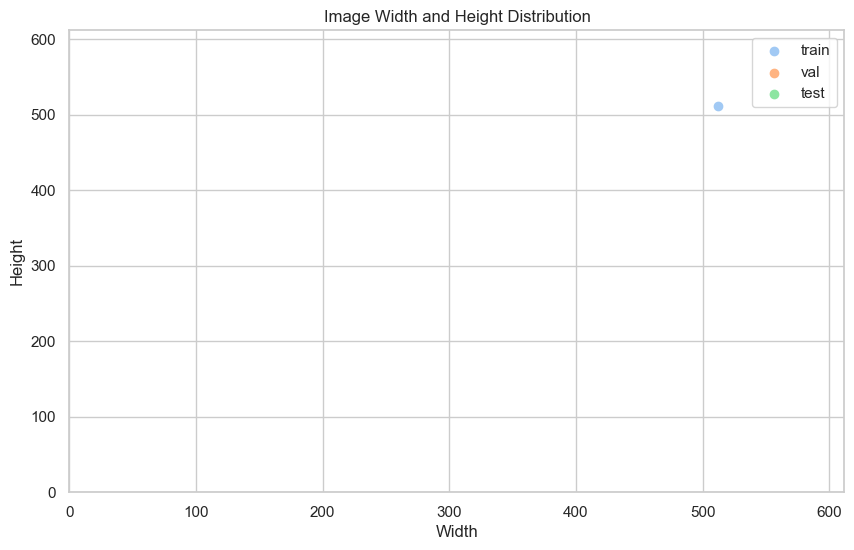

In [88]:
from data_gradients.feature_extractors.common.image_resolution import ImagesResolution
from data_gradients.utils.data_classes.data_samples import ImageSample
import matplotlib.pyplot as plt
from data_gradients.feature_extractors.abstract_feature_extractor import (
    AbstractFeatureExtractor,
)

# extract image width height distribution for all images in the loader
# Create an instance of ImagesResolution
images_resolution_extractor = ImagesResolution()

feature_width_height = 0

# Iterate through the entire training dataset
for batch in train_loader:
    image_data, label_data = batch  # Unpack the batch data
    # Create an ImageSample for each image in the batch
    for i in range(image_data.shape[0]):
        sample = ImageSample(
            sample_id=f"unique_id_{i}",  # set a unique ID for each sample
            image=image_data[i],  # Get the image data for this sample
            split="train",  # Set 'split' to the appropriate value
            image_channels=3,  # Assuming it's an RGB image
        )

        # Update the extractor with the ImageSample
        images_resolution_extractor.update(sample)
        # Get the aggregated feature
        feature = images_resolution_extractor.aggregate()

        # Plot If we find another value from 512x512
        if feature.data.height[0] != feature_width_height:
            feature_width_height = feature.data.height[0]
            plot_image_width_height_distribution(feature)


def plot_image_width_height_distribution(feature: AbstractFeatureExtractor):
    # Extract data from the Feature object
    scatter_data = feature.data
    scatter_plot_options = feature.plot_options
    print(scatter_plot_options.x_label_key)

    fig, ax = plt.subplots(figsize=scatter_plot_options.figsize)

    # Iterate through unique values of 'split'
    for split, color in scatter_plot_options.labels_palette.items():
        x_data = scatter_data["width"][scatter_data["split"] == split]
        y_data = scatter_data["height"][scatter_data["split"] == split]
        ax.scatter(x_data, y_data, label=split, c=[color])

    # Set plot labels and limits
    ax.set_xlabel(scatter_plot_options.x_label_name)
    ax.set_ylabel(scatter_plot_options.y_label_name)
    ax.set_xlim(scatter_plot_options.x_lim)
    ax.set_ylim(scatter_plot_options.y_lim)

    # Add legend
    ax.legend()

    # Add title
    ax.set_title(scatter_plot_options.title)

    # Optionally, adjust the rotation of x and y ticks if needed
    if scatter_plot_options.x_ticks_rotation:
        plt.xticks(rotation=scatter_plot_options.x_ticks_rotation)
    if scatter_plot_options.y_ticks_rotation:
        plt.yticks(rotation=scatter_plot_options.y_ticks_rotation)

    # Show the plot
    plt.show()

#### Bounding Box calculation

Distribution of Bounding Box Areas refers to the distribution of the areas of bounding boxes, calculated as a percentage of the total image area. This can be analyzed for each class individually, or collectively across all classes, providing insights into the variety of object sizes present in your dataset.


#### Bounding Box Customized Class


In [145]:
import math

import numpy as np
import pandas as pd

from data_gradients.common.registry.registry import register_feature_extractor
from data_gradients.feature_extractors.abstract_feature_extractor import Feature
from data_gradients.utils.data_classes import DetectionSample
from data_gradients.visualize.seaborn_renderer import ViolinPlotOptions
from data_gradients.feature_extractors.abstract_feature_extractor import (
    AbstractFeatureExtractor,
)


# @register_feature_extractor()
class CustomDetectionBoundingBoxArea(AbstractFeatureExtractor):
    def __init__(self):
        self.data = []
        self.hist_transform_name = "sqrt"
        transforms = {"sqrt": lambda bbox_area: int(math.sqrt(max(1, abs(bbox_area))))}
        self.hist_transform = transforms[self.hist_transform_name]

    def update(self, sample: DetectionSample):
        image_area = sample.image.shape[0] * sample.image.shape[1]
        for class_id, bbox_xyxy in zip(sample.class_ids, sample.bboxes_xyxy):
            class_name = sample.class_names[class_id]
            bbox_area = (bbox_xyxy[2] - bbox_xyxy[0]) * (bbox_xyxy[3] - bbox_xyxy[1])
            if bbox_area < 0:
                # Handle negative bbox_area values
                bbox_area = abs(bbox_area)

            self.data.append(
                {
                    "split": sample.split,
                    "class_id": class_id,
                    "class_name": class_name,
                    "relative_bbox_area": 100 * (bbox_area.item() / image_area),
                    f"bbox_area_{self.hist_transform_name}": self.hist_transform(
                        bbox_area
                    ),
                }
            )

    def aggregate(self) -> Feature:
        df = pd.DataFrame(self.data)
        # Remove duplicate rows based on 'class_id' and 'split' columns by taking the mean
        subset_columns = [
            "split",
            "class_id",
            "class_name",
            "relative_bbox_area",
            "bbox_area_sqrt",
        ]
        df = df.drop_duplicates(subset=subset_columns)
        # Set display options to show all columns
        pd.set_option("display.max_columns", None)
        pd.reset_option("display.max_columns")
        # Height of the plot is proportional to the number of classes
        n_unique = len(df["class_name"].unique())
        figsize_x = 10
        figsize_y = min(max(6, int(n_unique * 0.3)), 175)
        max_area = min(100, df["relative_bbox_area"].max())
        plot_options = ViolinPlotOptions(
            x_label_key="relative_bbox_area",
            x_label_name="Bounding Box Area (in % of image)",
            y_label_key="class_name",
            y_label_name="Class",
            order_key="class_id",
            title=self.title,
            x_ticks_rotation=None,
            labels_key="split",
            x_lim=(0, max_area),
            figsize=(figsize_x, figsize_y),
            bandwidth=0.4,
            tight_layout=True,
        )

        json = {}

        feature = Feature(
            data=df,
            plot_options=plot_options,
            json=json,
        )

        return feature

    @property
    def title(self) -> str:
        return "Distribution of Bounding Box Area"

    @property
    def description(self) -> str:
        return (
            "This graph shows the frequency of each class's appearance in the dataset. "
            "This can highlight distribution gap in object size between the training and validation splits, which can harm the model's performance. \n"
            "Another thing to keep in mind is that having too many very small objects may indicate that your are downsizing your original image to a "
            "low resolution that is not appropriate for your objects."
        )

#### Detection of Bounding Box Area for Train Dataset


In [146]:
# Create an instance of DetectionBoundingBoxArea
detection_bbox_area_extractor = CustomDetectionBoundingBoxArea()

class_names = ["pistol", "smartphone", "knife", "monedero", "billete", "tarjeta"]

# Iterate through the entire training dataset
for batch in test_loader:
    image_data, label_data = batch  # Unpack the batch data
    for i in range(image_data.shape[0]):
        # Create a DetectionSample for each image in the batch
        sample = DetectionSample(
            sample_id=f"unique_id_{i}",  # set a unique ID for each sample
            image=image_data[i],  # Get the image data for this sample
            split="train",  # Set 'split' to the appropriate value
            bboxes_xyxy=label_data[:, :, 1:].reshape(-1, 4),
            class_ids=label_data[:, :, :1].reshape(-1).to(torch.int),  # Class_ids
            class_names=class_names,  # List of class names in your dataset
            image_channels=3,  # it's an RGB image
        )

        # Update the extractor with the DetectionSample
        detection_bbox_area_extractor.update(sample)

# Get the aggregated feature
feature_train = detection_bbox_area_extractor.aggregate()

# print the feature_train
feature_train.data.head(10)

,split,class_id,class_name,relative_bbox_area,bbox_area_sqrt
0,train,"tensor(2, dtype=torch.int32)",knife,8.864457e-06,1
1,train,"tensor(1, dtype=torch.int32)",smartphone,6.937272e-06,1
2,train,"tensor(1, dtype=torch.int32)",smartphone,7.396222e-06,1
3,train,"tensor(4, dtype=torch.int32)",billete,1.456806e-07,1
4,train,"tensor(2, dtype=torch.int32)",knife,1.113285e-05,1
5,train,"tensor(2, dtype=torch.int32)",knife,2.525235e-06,1
6,train,"tensor(2, dtype=torch.int32)",knife,4.782265e-06,1
7,train,"tensor(2, dtype=torch.int32)",knife,3.581174e-05,1
8,train,"tensor(2, dtype=torch.int32)",knife,8.864457e-06,1
9,train,"tensor(1, dtype=torch.int32)",smartphone,6.937272e-06,1


#### Detection of Bounding Box Area for Test Dataset


In [147]:
# Create an instance of DetectionBoundingBoxArea
detection_bbox_area_extractor = CustomDetectionBoundingBoxArea()

class_names = ["pistol", "smartphone", "knife", "monedero", "billete", "tarjeta"]

# Iterate through the entire training dataset
for batch in test_loader:
    image_data, label_data = batch  # Unpack the batch data
    for i in range(image_data.shape[0]):
        # Create a DetectionSample for each image in the batch
        sample = DetectionSample(
            sample_id=f"unique_id_{i}",  # set a unique ID for each sample
            image=image_data[i],  # Get the image data for this sample
            split="test",  # Set 'split' to the appropriate value
            bboxes_xyxy=label_data[:, :, 1:].reshape(-1, 4),
            class_ids=label_data[:, :, :1].reshape(-1).to(torch.int),  # Class_ids
            class_names=class_names,  # List of class names in your dataset
            image_channels=3,  # it's an RGB image
        )

        # Update the extractor with the DetectionSample
        detection_bbox_area_extractor.update(sample)

# Get the aggregated feature
feature_test = detection_bbox_area_extractor.aggregate()

# Optionally, print the feature or save it to a file
feature_test.data.head(10)

,split,class_id,class_name,relative_bbox_area,bbox_area_sqrt
0,test,"tensor(2, dtype=torch.int32)",knife,8.864457e-06,1
1,test,"tensor(1, dtype=torch.int32)",smartphone,6.937272e-06,1
2,test,"tensor(1, dtype=torch.int32)",smartphone,7.396222e-06,1
3,test,"tensor(4, dtype=torch.int32)",billete,1.456806e-07,1
4,test,"tensor(2, dtype=torch.int32)",knife,1.113285e-05,1
5,test,"tensor(2, dtype=torch.int32)",knife,2.525235e-06,1
6,test,"tensor(2, dtype=torch.int32)",knife,4.782265e-06,1
7,test,"tensor(2, dtype=torch.int32)",knife,3.581174e-05,1
8,test,"tensor(2, dtype=torch.int32)",knife,8.864457e-06,1
9,test,"tensor(1, dtype=torch.int32)",smartphone,6.937272e-06,1


#### Concat the two dataframes to get the split of the Violine Plot and visualize the corresponding Bounding Areas


In [148]:
# Concatenate the DataFrames along the same column
result = pd.concat([feature_train.data, feature_test.data], axis=0)

# Reset the index
feature_full_df = result.reset_index(drop=True)

feature_full_df.head(5)

,split,class_id,class_name,relative_bbox_area,bbox_area_sqrt
0,train,"tensor(2, dtype=torch.int32)",knife,8.864457e-06,1
1,train,"tensor(1, dtype=torch.int32)",smartphone,6.937272e-06,1
2,train,"tensor(1, dtype=torch.int32)",smartphone,7.396222e-06,1
3,train,"tensor(4, dtype=torch.int32)",billete,1.456806e-07,1
4,train,"tensor(2, dtype=torch.int32)",knife,1.113285e-05,1


In [149]:
feature_full_df.tail(5)

,split,class_id,class_name,relative_bbox_area,bbox_area_sqrt
13659,test,"tensor(5, dtype=torch.int32)",tarjeta,5.199524e-06,1
13660,test,"tensor(3, dtype=torch.int32)",monedero,3.277756e-06,1
13661,test,"tensor(1, dtype=torch.int32)",smartphone,2.085420e-06,1
13662,test,"tensor(1, dtype=torch.int32)",smartphone,6.876549e-06,1
13663,test,"tensor(4, dtype=torch.int32)",billete,6.105500e-08,1


#### Distribution of Bounding Box Areas

- To calculate the distribution of bounding box area, iterate over all the images in your dataset.

- For each image, calculate the area of each bounding box as a percentage of the total image area. This is done by dividing the bounding box’s area by the image’s area and multiplying by 100. Do this separately for the training and validation sets.


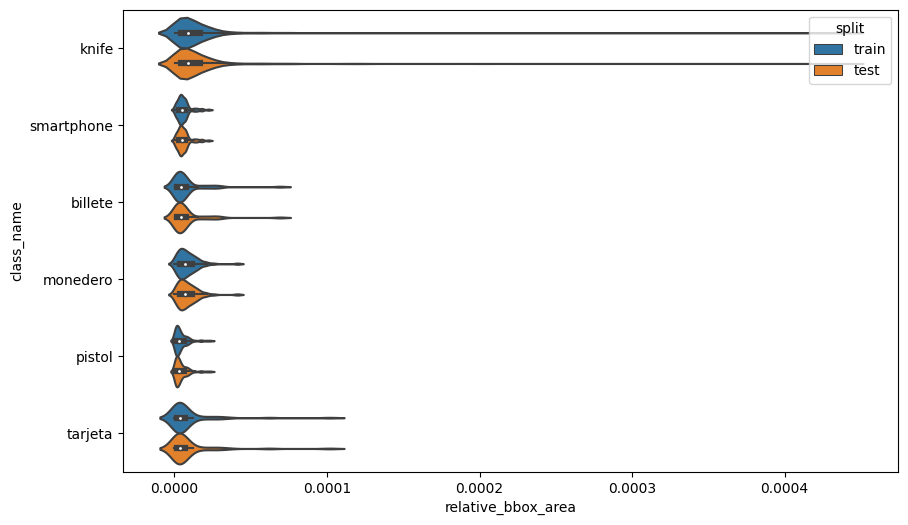

In [150]:
# Create the violin plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(
    data=feature_full_df, x="relative_bbox_area", y="class_name", hue="split"
)

# Show the plot
plt.show()

#### Class Frequency

- Class Frequency refers to the frequency of instances of each class in the dataset.

- Class Frequency measures the count of instances for each class in the dataset. With this measure, we can gain an accurate understanding of how classes are distributed across the dataset.


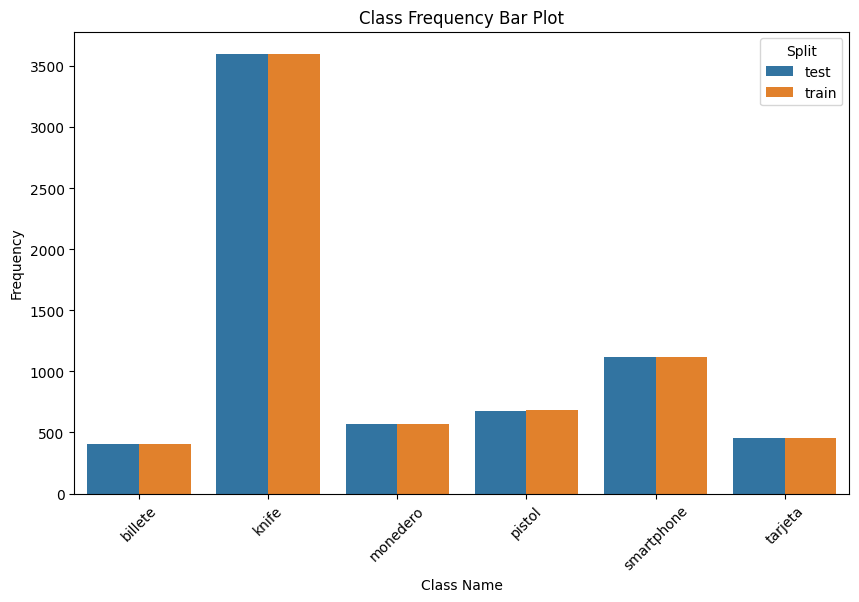

In [152]:
# Count the frequency of each class in each split
class_frequencies = (
    feature_full_df.groupby(["split", "class_name"]).size().reset_index(name="count")
)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="class_name", y="count", hue="split", data=class_frequencies)
plt.title("Class Frequency Bar Plot")
plt.xlabel("Class Name")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.legend(title="Split")
plt.show()